### Libraries

In [16]:
import os
from google.cloud import texttospeech
from pydub import AudioSegment

import pandas as pd

# speech_v1p1beta1 is able to give word information
from google.cloud import speech_v1p1beta1 as speech
from google.cloud.speech_v1p1beta1 import enums
from google.cloud.speech_v1p1beta1 import types

In [2]:
from credential_path import credential_path
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path

### Generate speech

Google Text-to-Speech docs: https://cloud.google.com/text-to-speech/docs/

SSML docs: https://cloud.google.com/text-to-speech/docs/ssml

In [3]:
def text_to_speech(ssml, file):
    client = texttospeech.TextToSpeechClient()

    synthesis_input = texttospeech.types.SynthesisInput(ssml=ssml)

    voice = texttospeech.types.VoiceSelectionParams(
        language_code='en-US',
        ssml_gender=texttospeech.enums.SsmlVoiceGender.NEUTRAL)

    audio_config = texttospeech.types.AudioConfig(
        audio_encoding=texttospeech.enums.AudioEncoding.LINEAR16)

    response = client.synthesize_speech(synthesis_input, voice, audio_config)

    with open(file, 'wb') as out:
        out.write(response.audio_content)

In [4]:
text_to_speech("""
<speak>
    The quick brown fox jumps over the lazy dog.
</speak>
""", 'true.wav')
true_audio = AudioSegment.from_wav('true.wav')
true_audio

Generate user audio, same as true except the word ```fox``` is slowed down.

In [5]:
text_to_speech("""
<speak>
    The quick brown <prosody rate="slow">fox</prosody> jumps over the lazy dog.
</speak>
""", 'user.wav')
user_audio = AudioSegment.from_mp3('user.wav')
user_audio

### Evaluate speech

Google Speech-to-Text docs: https://cloud.google.com/speech-to-text/docs/

In [6]:
def speech_to_text(speech_file):
    
    client = speech.SpeechClient()

    with open(speech_file, 'rb') as audio_file:
        content = audio_file.read()

    audio = types.RecognitionAudio(content=content)
    
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=24000,
        language_code='en-US',
        enable_word_confidence=True,
        enable_word_time_offsets=True,
    )

    response = client.recognize(config, audio)
    
    return response

In [7]:
true_response = speech_to_text('true.wav')
true_response

results {
  alternatives {
    transcript: "the quick brown fox jumps over the lazy dog"
    confidence: 0.9799774885177612
    words {
      start_time {
      }
      end_time {
        nanos: 200000000
      }
      word: "the"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 200000000
      }
      end_time {
        nanos: 500000000
      }
      word: "quick"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 500000000
      }
      end_time {
        nanos: 500000000
      }
      word: "brown"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 500000000
      }
      end_time {
        nanos: 900000000
      }
      word: "fox"
      confidence: 0.9876290559768677
    }
    words {
      start_time {
        nanos: 900000000
      }
      end_time {
        seconds: 1
        nanos: 600000000
      }
      word: "jumps"
      confidence: 0.9111142754554749
    }
 

In [8]:
user_response = speech_to_text('user.wav')

Convert Google response to more readable dataframe:

In [9]:
def response_to_df(response):
    words = []
    for word in response.results[0].alternatives[0].words:
        start = word.start_time.seconds*10**3+10**-6*word.start_time.nanos
        end = word.end_time.seconds*10**3+10**-6*word.end_time.nanos
        words.append({
            'word': word.word,
            'confidence': word.confidence,
            'start': start,
            'end': end,
            'dif': end-start,
        })
    return pd.DataFrame(words)

In [10]:
true_df = response_to_df(true_response)
true_df

,confidence,dif,end,start,word
0,0.987629,200.0,200.0,0.0,the
1,0.987629,300.0,500.0,200.0,quick
2,0.987629,0.0,500.0,500.0,brown
3,0.987629,400.0,900.0,500.0,fox
4,0.911114,700.0,1600.0,900.0,jumps
5,0.987629,100.0,1700.0,1600.0,over
6,0.987629,100.0,1800.0,1700.0,the
7,0.987629,200.0,2000.0,1800.0,lazy
8,0.987629,300.0,2300.0,2000.0,dog


In [11]:
user_df = response_to_df(user_response)
user_df

,confidence,dif,end,start,word
0,0.987629,200.0,200.0,0.0,the
1,0.987629,300.0,500.0,200.0,quick
2,0.987629,0.0,500.0,500.0,brown
3,0.987629,700.0,1200.0,500.0,fox
4,0.844559,1300.0,2500.0,1200.0,jumps
5,0.926127,100.0,2600.0,2500.0,over
6,0.987629,100.0,2700.0,2600.0,the
7,0.987629,200.0,2900.0,2700.0,lazy
8,0.987629,400.0,3300.0,2900.0,dog


### Compare timing user to correct timing

Plot adjusted from https://stackoverflow.com/questions/21397549/stack-bar-plot-in-matplotlib-and-add-label-to-each-section-and-suggestions

Darker green indicates better timing. Although the word ```fox``` is slowed down, somehow Google speech-to-text finds ```jumps``` is slowed down.

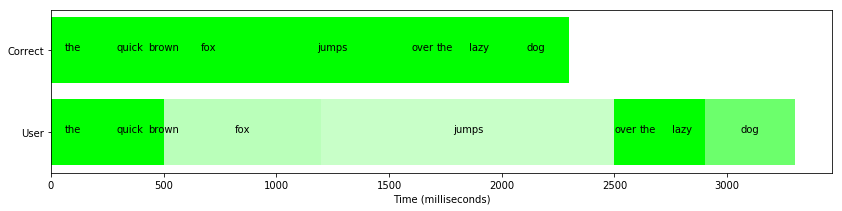

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


data = np.array([user_df.dif.values, true_df.dif.values]).T
percentages = np.array([user_df.word.values, true_df.word.values])
y_pos = np.arange(2)

fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(111)

patch_handles = []
left = np.zeros(2) # left alignment of data starts at zero
for i, d in enumerate(data):
    # score calculation, lower is better
    if d[0] == 0:
        score = 0
    else:
        score = abs(d[1]-d[0])/d[0]
    penalty = 1.7
    color = (score*penalty, 1, score*penalty)
    patch_handles.append(ax.barh(y_pos, d, 
      color=color, align='center', 
      left=left))
    # accumulate the left-hand offsets
    left += d

# go through all of the bar segments and annotate
for j in range(len(patch_handles)):
    for i, patch in enumerate(patch_handles[j].get_children()):
        if i == 1:
            patch.set_facecolor((0, 1, 0))
        bl = patch.get_xy()
        x = 0.5*patch.get_width() + bl[0]
        y = 0.5*patch.get_height() + bl[1]
        ax.text(x,y, percentages[i,j], ha='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(('User', 'Correct'))
ax.set_xlabel('Time (milliseconds)');